=== 1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ===
            name     role         type
0          state  Feature      Integer
1         county  Feature      Integer
2      community  Feature      Integer
3  communityname  Feature  Categorical
4           fold  Feature      Integer
5     population  Feature   Continuous
6  householdsize  Feature   Continuous
7   racepctblack  Feature   Continuous
8   racePctWhite  Feature   Continuous
9   racePctAsian  Feature   Continuous

=== 2. БАЗОВАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ ===

Linear Regression Results:
ОБУЧАБЩЕЕ - СКО: 0.0158, R²: 0.7153
ТЕСТОВОЕ  - СКО: 0.0185, R²: 0.6135

=== 3. ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ ===
Ступень 1: Общучающее СКО = 0.0158, Тестовое СКО = 0.0185
Ступень 2: Общучающее СКО = 0.0000, Тестовое СКО = 0.0751
Ступень 3: Общучающее СКО = 0.0000, Тестовое СКО = 0.0462

=== 4. РЕГУЛЯРИЗАЦИЯ ===

Ridge регрессия:
Альфа 0.0001: Обучающая СКО(средняя квадратичная ошибка) = 0.0158, Тестовая СКО = 0.0185
Альфа 0.001: Обучающая СКО(средняя квадратичная 

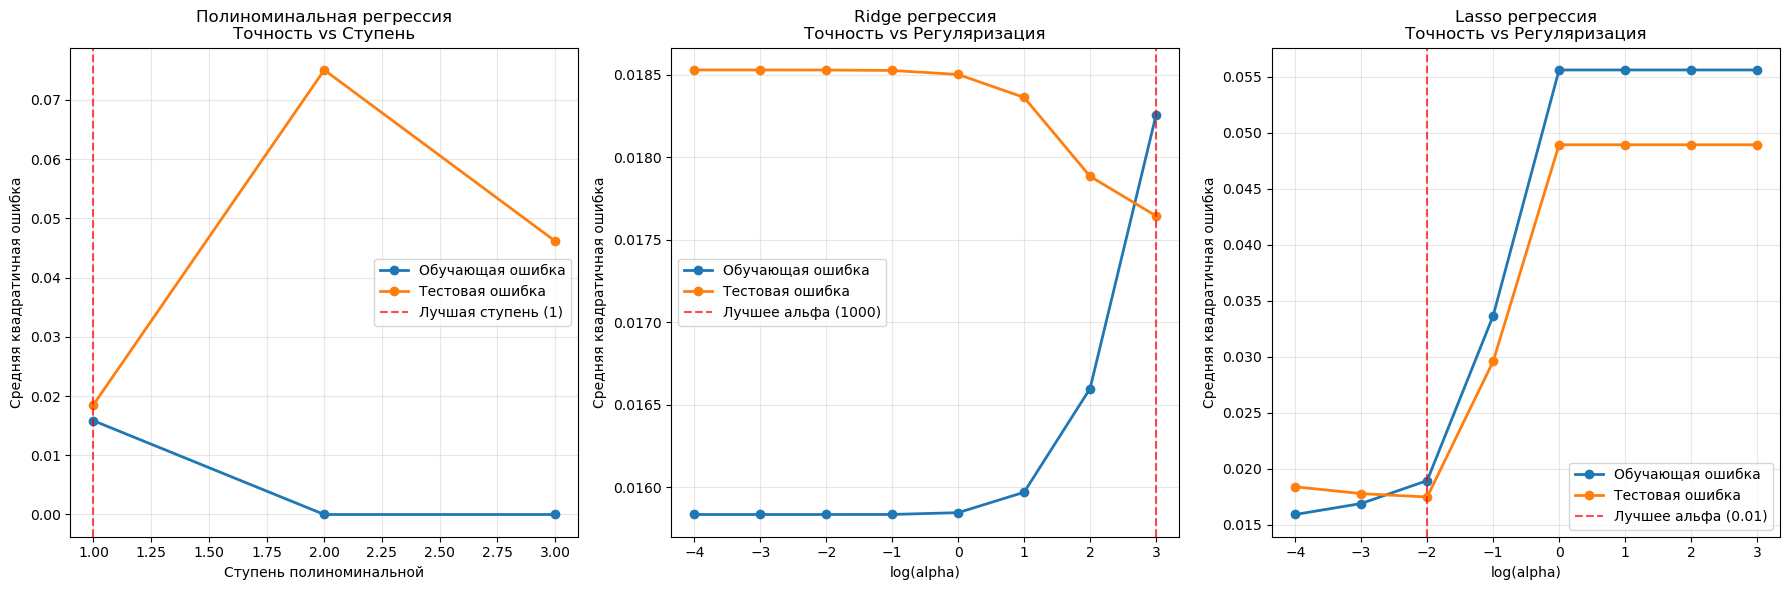

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


def data_definition():
    communities_crime = fetch_ucirepo(id=183)
    print(communities_crime.variables[['name', 'role', 'type']].head(10))
    return communities_crime.data.features, communities_crime.data.targets


def splitter(X, y):
    np.random.seed(42)
    selection = np.random.permutation(len(X))
    size = int(len(X) * 0.2)
    test_selection = selection[:size]
    train_selection = selection[size:]
    x_train, x_test = X.iloc[train_selection], X.iloc[test_selection]
    y_train, y_test = y.iloc[train_selection], y.iloc[test_selection]
    return x_train, x_test, y_train, y_test


def preprocess_data(X):
    """Предобработка данных"""
    X_processed = X.copy()
    
    # Пропущенные значения меняются с '?' на NaN
    X_processed = X_processed.replace('?', np.nan)
    
    # Преобразование колонок в числовой формат
    for col in X_processed.columns:
        X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')
    
    # Заполнение пропущенных значений медианой
    X_processed = X_processed.fillna(X_processed.median())
    
    # Удаление констант
    constant_columns = [col for col in X_processed.columns if X_processed[col].nunique() <= 1]
    X_processed = X_processed.drop(columns=constant_columns)
    
    return X_processed


if __name__ == '__main__':
    # 1. Загрузка и подготовка данных
    print("=== 1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ===")
    x, y = data_definition()
    
    # Предобработка данных
    x = preprocess_data(x)
    
    # Удаление строк с пропущенными значениями в целевой переменной
    valid_indices = ~y.isnull().any(axis=1)
    x = x[valid_indices]
    y = y[valid_indices]
    
    x_train, x_test, y_train, y_test = splitter(x, y)
    
    # Масштабирование для улучшения сходимости
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # 2. БАЗОВАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ
    print("\n=== 2. БАЗОВАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ ===")
    regressor = LinearRegression().fit(x_train_scaled, y_train)
    
    # Оценка точности
    y_pred_train = regressor.predict(x_train_scaled)
    y_pred_test = regressor.predict(x_test_scaled)
    
    print("\nLinear Regression Results:")
    print(f"ОБУЧАБЩЕЕ - СКО: {mean_squared_error(y_train, y_pred_train):.4f}, R²: {r2_score(y_train, y_pred_train):.4f}")
    print(f"ТЕСТОВОЕ  - СКО: {mean_squared_error(y_test, y_pred_test):.4f}, R²: {r2_score(y_test, y_pred_test):.4f}")

    # 3. ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ
    print("\n=== 3. ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ ===")
    train_errors_poly = []
    test_errors_poly = []
    train_r2_poly = []
    test_r2_poly = []
    degrees = range(1, 4)

    for degree in degrees:
        polynom = PolynomialFeatures(degree=degree)
        x_train_poly = polynom.fit_transform(x_train_scaled)
        x_test_poly = polynom.transform(x_test_scaled)

        model = LinearRegression()
        model.fit(x_train_poly, y_train)

        y_train_pred = model.predict(x_train_poly)
        y_test_pred = model.predict(x_test_poly)

        train_errors_poly.append(mean_squared_error(y_train, y_train_pred))
        test_errors_poly.append(mean_squared_error(y_test, y_test_pred))
        train_r2_poly.append(r2_score(y_train, y_train_pred))
        test_r2_poly.append(r2_score(y_test, y_test_pred))
        
        print(f"Ступень {degree}: Общучающее СКО = {train_errors_poly[-1]:.4f}, Тестовое СКО = {test_errors_poly[-1]:.4f}")

    # 4. РЕГУЛЯРИЗАЦИЯ
    print("\n=== 4. РЕГУЛЯРИЗАЦИЯ ===")
    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    
    # Ridge регрессия
    ridge_train_errors = []
    ridge_test_errors = []
    ridge_train_r2 = []
    ridge_test_r2 = []
    
    # Lasso регрессия
    lasso_train_errors = []
    lasso_test_errors = []
    lasso_train_r2 = []
    lasso_test_r2 = []

    print("\nRidge регрессия:")
    for alpha in alphas:
        # Ridge
        ridge = Ridge(alpha=alpha)
        ridge.fit(x_train_scaled, y_train)
        
        ridge_train_pred = ridge.predict(x_train_scaled)
        ridge_test_pred = ridge.predict(x_test_scaled)
        
        ridge_train_errors.append(mean_squared_error(y_train, ridge_train_pred))
        ridge_test_errors.append(mean_squared_error(y_test, ridge_test_pred))
        ridge_train_r2.append(r2_score(y_train, ridge_train_pred))
        ridge_test_r2.append(r2_score(y_test, ridge_test_pred))
        
        print(f"Альфа {alpha}: Обучающая СКО(средняя квадратичная ошибка) = {ridge_train_errors[-1]:.4f}, Тестовая СКО = {ridge_test_errors[-1]:.4f}")

    print("\nLasso регрессия:")
    for alpha in alphas:
        # Lasso
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(x_train_scaled, y_train.values.ravel())
        
        lasso_train_pred = lasso.predict(x_train_scaled)
        lasso_test_pred = lasso.predict(x_test_scaled)
        
        lasso_train_errors.append(mean_squared_error(y_train, lasso_train_pred))
        lasso_test_errors.append(mean_squared_error(y_test, lasso_test_pred))
        lasso_train_r2.append(r2_score(y_train, lasso_train_pred))
        lasso_test_r2.append(r2_score(y_test, lasso_test_pred))
        
        print(f"Альфа {alpha}: Обучающая СКО = {lasso_train_errors[-1]:.4f}, Тестовая СКО = {lasso_test_errors[-1]:.4f}")

    # Сравнение результатов
    print("\n=== СРАВНЕНИЕ МЕТОДОВ ===")
    
    # Лучшая полиномиальная модель
    best_poly_idx = np.argmin(test_errors_poly)
    best_poly_degree = degrees[best_poly_idx]
    best_poly_error = test_errors_poly[best_poly_idx]
    
    # Лучшая Ridge модель
    best_ridge_idx = np.argmin(ridge_test_errors)
    best_ridge_alpha = alphas[best_ridge_idx]
    best_ridge_error = ridge_test_errors[best_ridge_idx]
    
    # Лучшая Lasso модель
    best_lasso_idx = np.argmin(lasso_test_errors)
    best_lasso_alpha = alphas[best_lasso_idx]
    best_lasso_error = lasso_test_errors[best_lasso_idx]
    
    print(f"Лучшая полиноминальная (ступень={best_poly_degree}): СКО = {best_poly_error:.4f}")
    print(f"Лучшая Ridge (альфа={best_ridge_alpha}): СКО = {best_ridge_error:.4f}")
    print(f"Лучшая Lasso (альфа={best_lasso_alpha}): СКО = {best_lasso_error:.4f}")
    
    # Определение лучшего метода
    methods = {
        'Linear': mean_squared_error(y_test, y_pred_test),
        'Polynomial': best_poly_error,
        'Ridge': best_ridge_error,
        'Lasso': best_lasso_error
    }
    best_method = min(methods, key=methods.get)
    print(f"\n Лучший метод - {best_method} со средней квадратичной ошибкой = {methods[best_method]:.4f}")

    # ВИЗУАЛИЗАЦИЯ
    print("\n=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===")
    plt.figure(figsize=(18, 6))
    
    # 3. График полиномиальной регрессии
    plt.subplot(1, 3, 1)
    plt.plot(degrees, train_errors_poly, 'o-', label='Обучающая ошибка', linewidth=2)
    plt.plot(degrees, test_errors_poly, 'o-', label='Тестовая ошибка', linewidth=2)
    plt.axvline(x=best_poly_degree, color='red', linestyle='--', alpha=0.7, label=f'Лучшая ступень ({best_poly_degree})')
    plt.xlabel('Ступень полиноминальной')
    plt.ylabel('Средняя квадратичная ошибка')
    plt.title('Полиноминальная регрессия\nТочность vs Ступень')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. График Ridge регрессии
    plt.subplot(1, 3, 2)
    plt.plot(np.log10(alphas), ridge_train_errors, 'o-', label='Обучающая ошибка', linewidth=2)
    plt.plot(np.log10(alphas), ridge_test_errors, 'o-', label='Тестовая ошибка', linewidth=2)
    plt.axvline(x=np.log10(best_ridge_alpha), color='red', linestyle='--', alpha=0.7, 
                label=f'Лучшее альфа ({best_ridge_alpha})')
    plt.xlabel('log(alpha)')
    plt.ylabel('Средняя квадратичная ошибка')
    plt.title('Ridge регрессия\nТочность vs Регуляризация')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. График Lasso регрессии
    plt.subplot(1, 3, 3)
    plt.plot(np.log10(alphas), lasso_train_errors, 'o-', label='Обучающая ошибка', linewidth=2)
    plt.plot(np.log10(alphas), lasso_test_errors, 'o-', label='Тестовая ошибка', linewidth=2)
    plt.axvline(x=np.log10(best_lasso_alpha), color='red', linestyle='--', alpha=0.7, 
                label=f'Лучшее альфа ({best_lasso_alpha})')
    plt.xlabel('log(alpha)')
    plt.ylabel('Средняя квадратичная ошибка')
    plt.title('Lasso регрессия\nТочность vs Регуляризация')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()